In [1]:
# (Opsional) install paket jika perlu
# !pip install -q pandas numpy scikit-learn matplotlib joblib

import os, re, json, math, warnings, joblib
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

# --- Path & konstanta ---
SEED = 42
BASE = Path.cwd()            # notebook berada di folder: program/
DATASET = BASE.parent / "dataset" / "mobilbekas.csv"  # ../dataset/mobilbekas.csv
DIR_TRAIN = BASE / "data_training"
DIR_TEST  = BASE / "data_testing"
DIR_ART   = BASE / "artefak"

for d in [DIR_TRAIN, DIR_TEST, DIR_ART]:
    d.mkdir(parents=True, exist_ok=True)

print("Base:", BASE)
print("Dataset:", DATASET.exists(), DATASET)
print("Dirs:", DIR_TRAIN, "|", DIR_TEST, "|", DIR_ART)


Base: F:\DAFFA ULHAQ\SEMESTER 7\Proyek Sains Data\Program
Dataset: True F:\DAFFA ULHAQ\SEMESTER 7\Proyek Sains Data\dataset\mobilbekas.csv
Dirs: F:\DAFFA ULHAQ\SEMESTER 7\Proyek Sains Data\Program\data_training | F:\DAFFA ULHAQ\SEMESTER 7\Proyek Sains Data\Program\data_testing | F:\DAFFA ULHAQ\SEMESTER 7\Proyek Sains Data\Program\artefak


In [2]:
def to_num(s):
    """Konversi '1.550.000' atau '1,55' → float (Indonesia style)."""
    if pd.isna(s): return np.nan
    if isinstance(s, (int, float)): return float(s)
    s = str(s).strip().replace(".", "").replace(",", ".")
    s = re.sub(r"[^0-9\.\-]", "", s)
    return float(s) if s else np.nan

def parse_km_range(txt):
    """'85.000-90.000 km' atau '0-5.000 km' → angka rata-rata (km)."""
    if pd.isna(txt): return np.nan
    s = str(txt).lower().replace("km","")
    nums = re.findall(r"[\d\.\,]+", s)
    vals = [to_num(x) for x in nums]
    if len(vals)==0: return np.nan
    if len(vals)==1: return vals[0]
    return float(np.mean(vals))

def parse_cc_range(txt):
    """'>1.500 - 2.000 cc' → midpoint dalam cc."""
    if pd.isna(txt): return np.nan
    s = str(txt).lower().replace("cc","").replace(">","").replace("<","")
    nums = re.findall(r"[\d\.\,]+", s)
    vals = [to_num(x) for x in nums]
    if len(vals)==0: return np.nan
    if len(vals)==1: return vals[0]
    return float(np.mean(vals))

def split_lokasi(lok):
    """
    'Ngaliyan, Semarang Kota, Jawa Tengah' -> (Area, KotaKab, Provinsi).
    Graceful kalau cuma 1-2 segmen.
    """
    if pd.isna(lok): return (np.nan, np.nan, np.nan)
    parts = [p.strip() for p in str(lok).split(",")]
    if len(parts)==1: return (parts[0], np.nan, np.nan)
    if len(parts)==2: return (parts[0], parts[1], np.nan)
    return (parts[0], parts[1], parts[2])


In [3]:
assert DATASET.exists(), f"Tidak menemukan file: {DATASET}"
df_raw = pd.read_csv(DATASET)
print(df_raw.shape)
df_raw.head(5)


(14657, 16)


,Harga,Lokasi,Penjual,Merek,Model,Varian,Tahun,Jarak tempuh,Tipe bahan bakar,Warna,Transmisi,Tipe bodi,Kapasitas mesin,Tipe Penjual,Sistem Penggerak,Nama Bursa Mobil
0,155000792,"Ngaliyan, Semarang Kota, Jawa Tengah",Tegar Ranisdya,BMW,Serie 3,320i Business Edition,2006,85.000-90.000 km,Bensin,Hitam,Automatic,Sedan,>1.500 - 2.000 cc,Individu,NaN,NaN
1,56000000,"Medan Johor, Medan Kota, Sumatra Utara",Anda Syahwilhanto,Hyundai,Getz,Lain-lain,2005,0-5.000 km,Bensin,Biru,Manual,Hatchback,>1.000 - 1.500 cc,Individu,Front Wheel Drive (FWD),NaN
2,120000000,"Ilir Timur I, Palembang Kota, Sumatra Selatan",alvianistm,Isuzu,Grand touring,Lain-lain,2004,10.000-15.000 km,Diesel,Silver,Manual,NaN,NaN,Individu,NaN,NaN
3,169000000,"Balerejo, Madiun Kab., Jawa Timur",PUSAT MOBIL BEKAS SIDOARJO,Isuzu,Grand touring,Lain-lain,2010,100.000-105.000 km,Diesel,Coklat,Manual,Minibus,>2.000 - 3.000 cc,Diler,NaN,NaN
4,120000000,"Kemayoran, Jakarta Pusat, Jakarta D.K.I.",Kristian,Proton,Lain-lain,Lain-lain,2010,75.000-80.000 km,Bensin,Oranye,Manual,Pick-up,>1.500 - 2.000 cc,NaN,Rear Wheel Drive (RWD),Pasar Mobil Kemayoran


In [4]:
df = df_raw.copy()

# Pastikan kolom inti tersedia (buat jika hilang agar pipeline konsisten)
base_cols = ["Harga","Lokasi","Penjual","Merek","Model","Varian","Tahun","Jarak tempuh",
             "Tipe bahan bakar","Warna","Transmisi","Tipe bodi","Kapasitas mesin",
             "Tipe Penjual","Sistem Penggerak","Nama Bursa Mobil"]
for c in base_cols:
    if c not in df.columns:
        df[c] = np.nan

# Target & fitur numerik turunan
df["Harga"] = df["Harga"].apply(to_num)
df["Jarak_km"] = df["Jarak tempuh"].apply(parse_km_range)
df["CC_mid"]   = df["Kapasitas mesin"].apply(parse_cc_range)
df[["Area","KotaKab","Provinsi"]] = df["Lokasi"].apply(lambda x: pd.Series(split_lokasi(x)))
df["Tahun"] = pd.to_numeric(df["Tahun"], errors="coerce")
df["Usia_mobil"] = 2025 - df["Tahun"]

# Normalisasi ringan string
text_cols = ["Merek","Model","Varian","Tipe bahan bakar","Warna","Transmisi","Tipe bodi",
             "Tipe Penjual","Sistem Penggerak","Nama Bursa Mobil","Penjual",
             "Area","KotaKab","Provinsi"]
for c in text_cols:
    df[c] = df[c].astype(str).str.strip()

# Pilih fitur awal (bisa kamu tambah lagi)
num_cols = ["Tahun","Jarak_km","CC_mid","Usia_mobil"]
cat_cols = ["Merek","Model","Varian","Tipe bahan bakar","Transmisi","Tipe bodi","Sistem Penggerak",
            "Warna","Tipe Penjual","KotaKab","Provinsi","Nama Bursa Mobil"]
use_cols = ["Harga"] + num_cols + cat_cols

dfm = df[use_cols].copy()
dfm = dfm[~dfm["Harga"].isna()].copy()

# Trimming outlier ringan di target
low, high = dfm["Harga"].quantile([0.005, 0.995])
dfm = dfm[(dfm["Harga"]>=low) & (dfm["Harga"]<=high)].copy()

print("Setelah prep:", dfm.shape)
dfm.head(3)


Setelah prep: (14517, 17)


,Harga,Tahun,Jarak_km,CC_mid,Usia_mobil,Merek,Model,Varian,Tipe bahan bakar,Transmisi,Tipe bodi,Sistem Penggerak,Warna,Tipe Penjual,KotaKab,Provinsi,Nama Bursa Mobil
0,155000792.0,2006.0,87500.0,1750.0,19.0,BMW,Serie 3,320i Business Edition,Bensin,Automatic,Sedan,nan,Hitam,Individu,Semarang Kota,Jawa Tengah,nan
1,56000000.0,2005.0,2500.0,1250.0,20.0,Hyundai,Getz,Lain-lain,Bensin,Manual,Hatchback,Front Wheel Drive (FWD),Biru,Individu,Medan Kota,Sumatra Utara,nan
2,120000000.0,2004.0,12500.0,NaN,21.0,Isuzu,Grand touring,Lain-lain,Diesel,Manual,nan,nan,Silver,Individu,Palembang Kota,Sumatra Selatan,nan


In [5]:
# Stratifikasi regresi pakai bin harga agar distribusi mirip
# jumlah bin adaptif, minimal 5 maksimal 10
bins = min(10, max(5, int(np.sqrt(len(dfm))//50)))
dfm["_bin"] = pd.qcut(dfm["Harga"].rank(method="first"), q=bins, labels=False, duplicates="drop")

train_df, test_df = train_test_split(
    dfm.drop(columns=[]), test_size=0.2, random_state=SEED, stratify=dfm["_bin"]
)
train_df = train_df.drop(columns=["_bin"])
test_df  = test_df.drop(columns=["_bin"])

# Simpan
path_train = DIR_TRAIN / "train.csv"
path_test  = DIR_TEST  / "test.csv"
train_df.to_csv(path_train, index=False)
test_df.to_csv(path_test, index=False)

# Simpan meta
meta = {
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "target": "Harga",
    "log_target": True,
    "seed": SEED,
    "train_path": str(path_train.name),
    "test_path": str(path_test.name),
}
with open(DIR_ART/"meta.json","w") as f:
    json.dump(meta, f, indent=2)

print("Train/Test saved →", path_train, "|", path_test)
print("Baris:", len(train_df), "|", len(test_df))


Train/Test saved → F:\DAFFA ULHAQ\SEMESTER 7\Proyek Sains Data\Program\data_training\train.csv | F:\DAFFA ULHAQ\SEMESTER 7\Proyek Sains Data\Program\data_testing\test.csv
Baris: 11613 | 2904


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Load ulang agar idempoten
train_df = pd.read_csv(DIR_TRAIN/"train.csv")
test_df  = pd.read_csv(DIR_TEST/"test.csv")
TARGET = "Harga"

X_train, y_train = train_df.drop(columns=[TARGET]), train_df[TARGET]
X_test,  y_test  = test_df.drop(columns=[TARGET]),  test_df[TARGET]

# --- Preprocess: imputasi + OHE (drop='first' agar hindari dummy trap/multikolinearitas) ---
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore", drop='first')),
])

prep = ColumnTransformer([
    ("num", num_pipe, meta["num_cols"]),
    ("cat", cat_pipe, meta["cat_cols"]),
])

# --- Model multiple regression (OLS scikit-learn) ---
linreg = LinearRegression()  # Ordinary Least Squares

pipe = Pipeline([("prep", prep), ("model", linreg)])

# Opsi: tetap pakai log-target agar error relatif lebih stabil
use_log = meta.get("log_target", True)

if use_log:
    pipe.fit(X_train, np.log1p(y_train))
    y_pred_test = np.expm1(pipe.predict(X_test))
else:
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)
mape = (np.abs((y_test - y_pred_test)/y_test)).replace([np.inf,-np.inf], np.nan).dropna().mean()*100

print(f"[Multiple Regression] TEST → RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | R²: {r2:.3f} | MAPE: {mape:.2f}%")


[Multiple Regression] TEST → RMSE: 228,805,603 | MAE: 81,759,448 | R²: 0.508 | MAPE: 32.43%


In [8]:
# Simpan model pipeline multiple regression
model_path = DIR_ART / "model_linreg.pkl"
joblib.dump(pipe, model_path)

# Simpan prediksi pada test set
pred_path = DIR_TEST / "prediksi_test_linreg.csv"
pd.DataFrame({"y_true": y_test.values, "y_pred": y_pred_test}).to_csv(pred_path, index=False)

print("Model saved →", model_path)
print("Prediksi test →", pred_path)


Model saved → F:\DAFFA ULHAQ\SEMESTER 7\Proyek Sains Data\Program\artefak\model_linreg.pkl
Prediksi test → F:\DAFFA ULHAQ\SEMESTER 7\Proyek Sains Data\Program\data_testing\prediksi_test_linreg.csv


,y_true,y_pred,abs_err,pct_err
1889,3.400000e+09,7.124597e+08,2.687540e+09,79.045304
2459,3.250000e+09,6.682953e+08,2.581705e+09,79.437067
2191,3.400000e+09,9.493351e+08,2.450665e+09,72.078379
500,3.000000e+09,5.750714e+08,2.424929e+09,80.830954
2382,2.650000e+09,4.598236e+08,2.190176e+09,82.648166
91,2.773000e+09,6.153190e+08,2.157681e+09,77.810351
252,2.650000e+09,4.976852e+08,2.152315e+09,81.219425
2347,2.475000e+09,4.131545e+08,2.061846e+09,83.306890
265,2.650000e+09,6.703669e+08,1.979633e+09,74.703137
1438,2.600000e+09,6.891686e+08,1.910831e+09,73.493517


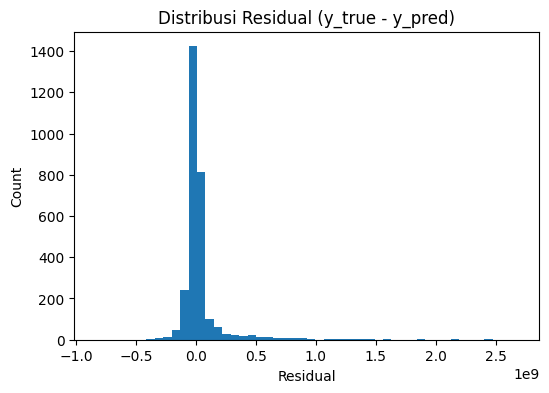

MAE (Rp): 81,759,448
RMSE (Rp): 228,805,603
MAPE (%): 32.43


In [9]:
err = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred_test,
    "abs_err": np.abs(y_test.values - y_pred_test),
    "pct_err": np.abs(y_test.values - y_pred_test) / y_test.values * 100
}).sort_values("abs_err", ascending=False)

display(err.head(10))

plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred_test, bins=50)
plt.title("Distribusi Residual (y_true - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

print("MAE (Rp):", f"{mae:,.0f}")
print("RMSE (Rp):", f"{rmse:,.0f}")
print("MAPE (%):", f"{mape:.2f}")


,feature,coef,abs_coef
39,Merek_Mercedes-Benz,0.399806,0.399806
1231,Sistem Penggerak_4X4,0.358134,0.358134
5,Merek_BMW,0.353827,0.353827
15,Merek_Datsun,-0.334043,0.334043
35,Merek_Land Rover,0.330370,0.330370
1224,Tipe bodi_Pick-up,-0.312173,0.312173
1220,Tipe bodi_Jeep,0.304600,0.304600
1213,Transmisi_Manual,-0.303100,0.303100
19,Merek_Ford,-0.287614,0.287614
30,Merek_Jeep,0.276803,0.276803


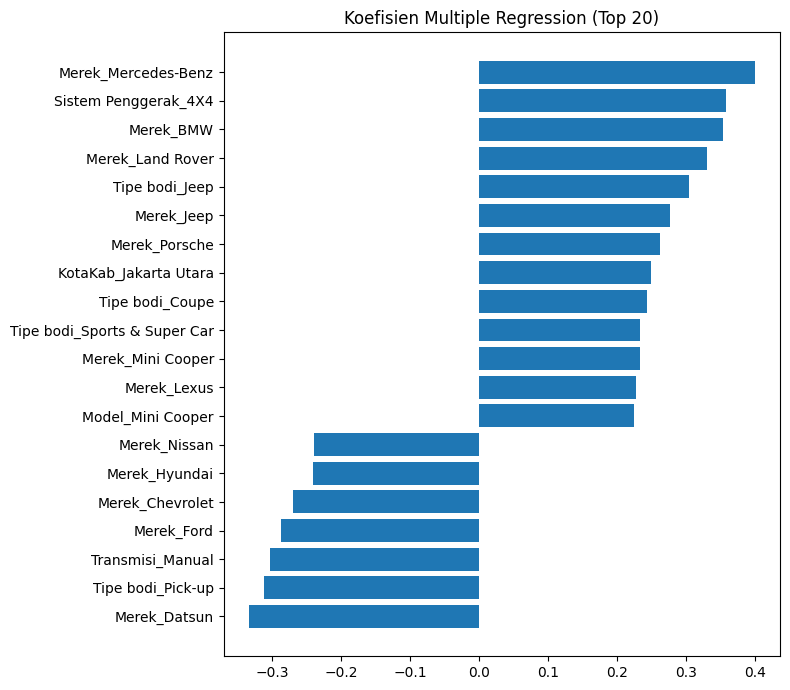

In [10]:
# Ambil nama fitur setelah transformasi
oh: OneHotEncoder = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["oh"]
cat_feature_names = oh.get_feature_names_out(meta["cat_cols"]).tolist()
feature_names = meta["num_cols"] + cat_feature_names

# Ambil koefisien model (kalau pakai log-target, interpretasi: perubahan log(Harga))
coefs = pipe.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

display(coef_df.head(30))  # 30 fitur paling berpengaruh

plt.figure(figsize=(8,7))
top = coef_df.head(20).sort_values("coef")
plt.barh(top["feature"], top["coef"])
plt.title("Koefisien Multiple Regression (Top 20)")
plt.tight_layout()
plt.show()


In [11]:
def predict_harga(df_in: pd.DataFrame, model_pkl=DIR_ART/"model_linreg.pkl"):
    mdl = joblib.load(model_pkl)
    needed = meta["num_cols"] + meta["cat_cols"]
    X_in = df_in.copy()
    for c in needed:
        if c not in X_in.columns:
            X_in[c] = np.nan
    X_in = X_in[needed]
    pred = mdl.predict(X_in)
    if meta.get("log_target", True):
        pred = np.expm1(pred)
    return pred

# Contoh pakai
sample = pd.DataFrame([{
    "Tahun": 2018, "Jarak_km": 30000, "CC_mid": 1500, "Usia_mobil": 2025-2018,
    "Merek": "Toyota", "Model": "Avanza", "Varian": "1.3 G",
    "Tipe bahan bakar": "Bensin", "Transmisi": "Automatic", "Tipe bodi":"MPV",
    "Sistem Penggerak":"Front Wheel Drive (FWD)", "Warna":"Hitam",
    "Tipe Penjual":"Individu", "KotaKab":"Bandung Kota", "Provinsi":"Jawa Barat",
    "Nama Bursa Mobil": np.nan
}])

pred_val = predict_harga(sample)[0]
print("Prediksi harga (Rp):", f"{pred_val:,.0f}")


Prediksi harga (Rp): 251,243,422
